<a href="https://colab.research.google.com/github/fehtemam/DataScienceSpCourseNotes/blob/master/Copy_of_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# uncomment to install libraries
#!pip install pandas numpy matplotlib seaborn sympy dowhy

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
!pip install git+https://github.com/microsoft/dowhy.git
import dowhy.api 

%matplotlib inline
url = 'https://raw.githubusercontent.com/jhlingle/causality-for-the-uninitiated/master/notebooks/data/churn.csv'
df = pd.read_csv(url, index_col=0)
print(df.head(5),"\n")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Cloning https://github.com/microsoft/dowhy.git to /tmp/pip-req-build-o45kst3b
  Running command git clone -q https://github.com/microsoft/dowhy.git /tmp/pip-req-build-o45kst3b
  Created wheel for dowhy: filename=dowhy-0.4-cp36-none-any.whl size=96451 sha256=0530115ede58bde1d895bab4a562b744ca83b3bac6ee94faec55dd6ead689f3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5bqniv1/wheels/b4/e9/95/efdead3eda88313a0fc098eda30e19bb65c0afe4a240468f4d
Successfully built dowhy
      host_is_superhost  price  ... churn  days_since_last_review
19444                 f  200.0  ...  True                   850.0
1520                  f  450.0  ...  True                   505.0
1517                  f   28.0  ...  True                  3650.0
21691                 f   48.0  ...  True                   612.0
21706                 f  160.0  ...  True                  3650.0

[5 rows x 20 columns] 



In [0]:
drop_columns = ['calendar_updated', 'review_scores_cleanliness', 'minimum_nights']
df.drop(drop_columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77201 entries, 19444 to 0
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               77201 non-null  object 
 1   price                           77201 non-null  float64
 2   room_type                       77201 non-null  object 
 3   accommodates                    77201 non-null  int64  
 4   review_scores_location          77201 non-null  float64
 5   review_scores_rating            77201 non-null  float64
 6   host_identity_verified          77201 non-null  object 
 7   host_response_time              77201 non-null  object 
 8   host_response_rate              77201 non-null  float64
 9   host_has_profile_pic            77201 non-null  object 
 10  availability_365                77201 non-null  float64
 11  calculated_host_listings_count  77201 non-null  float64
 12  number_of_reviews               

In [0]:
# filter outliers with unusually high prices and listings without reviews
df_robust = df[(df.price < df.price.quantile(.99)) & (df.reviews_per_month > 1)].drop(drop_columns, axis=1)
df_robust

host_is_superhost  price  ...  churn  days_since_last_review
22815                 t   79.0  ...   True                   503.0
22817                 f  210.0  ...   True                   517.0
24200                 f  100.0  ...   True                   429.0
23811                 f  200.0  ...   True                   429.0
23421                 f  180.0  ...   True                   438.0
...                 ...    ...  ...    ...                     ...
21715                 f  220.0  ...  False                     7.0
21719                 t  349.0  ...  False                    34.0
21723                 f   59.0  ...  False                     9.0
21712                 f  235.0  ...  False                     9.0
0                     t   49.0  ...  False                     4.0

[19193 rows x 17 columns]

In [0]:
# filter neighborhoods with at leastt 10 listings
neighborhood_ind = df_robust.neighbourhood.value_counts()[df_robust.neighbourhood.value_counts() > 25]

In [0]:
neighborhood_ind.index

Index(['Williamsburg', 'Hell's Kitchen', 'Bedford-Stuyvesant',
       'Upper East Side', 'Upper West Side', 'East Village', 'Harlem',
       'Bushwick', 'Lower East Side', 'Chelsea', 'East Harlem',
       'Alphabet City', 'Crown Heights', 'Astoria', 'West Village',
       'Washington Heights', 'Hamilton Heights', 'Greenpoint', 'Midtown East',
       'Clinton Hill', 'Park Slope', 'Midtown', 'Greenwich Village',
       'Kips Bay', 'Flatbush', 'Financial District', 'Chinatown', 'Soho',
       'Nolita', 'Fort Greene', 'Gramercy Park', 'Lefferts Garden',
       'Flatiron District', 'Murray Hill', 'Prospect Heights', 'Boerum Hill',
       'Sunnyside', 'Long Island City', 'Times Square/Theatre District',
       'Ridgewood', 'Morningside Heights', 'Sunset Park', 'Ditmars / Steinway',
       'Jamaica', 'Carroll Gardens', 'Flushing', 'Tribeca', 'Jackson Heights',
       'Brooklyn Heights', 'Downtown Brooklyn', 'Meatpacking District',
       'Elmhurst', 'Inwood', 'East Flatbush', 'Union Square', 

In [0]:
df_sample = df_robust[df_robust.neighbourhood.isin(neighborhood_ind.index)]
df_sample

host_is_superhost  price  ...  churn  days_since_last_review
22815                 t   79.0  ...   True                   503.0
22817                 f  210.0  ...   True                   517.0
24200                 f  100.0  ...   True                   429.0
23811                 f  200.0  ...   True                   429.0
23421                 f  180.0  ...   True                   438.0
...                 ...    ...  ...    ...                     ...
21727                 f  150.0  ...  False                    20.0
21711                 f  360.0  ...  False                    23.0
21715                 f  220.0  ...  False                     7.0
21723                 f   59.0  ...  False                     9.0
21712                 f  235.0  ...  False                     9.0

[15873 rows x 17 columns]

In [0]:
df_sample.corr()

price  ...  days_since_last_review
price                           1.000000  ...                0.043644
accommodates                    0.531858  ...               -0.012861
review_scores_location          0.184219  ...               -0.051390
review_scores_rating            0.068662  ...               -0.102509
host_response_rate              0.003928  ...               -0.208425
availability_365                0.053212  ...                0.053499
calculated_host_listings_count -0.150241  ...                0.040069
number_of_reviews              -0.016340  ...               -0.169266
reviews_per_month              -0.056087  ...               -0.128557
churn                           0.071592  ...                0.766564
days_since_last_review          0.043644  ...                1.000000

[11 rows x 11 columns]

<Figure size 720x720 with 0 Axes>

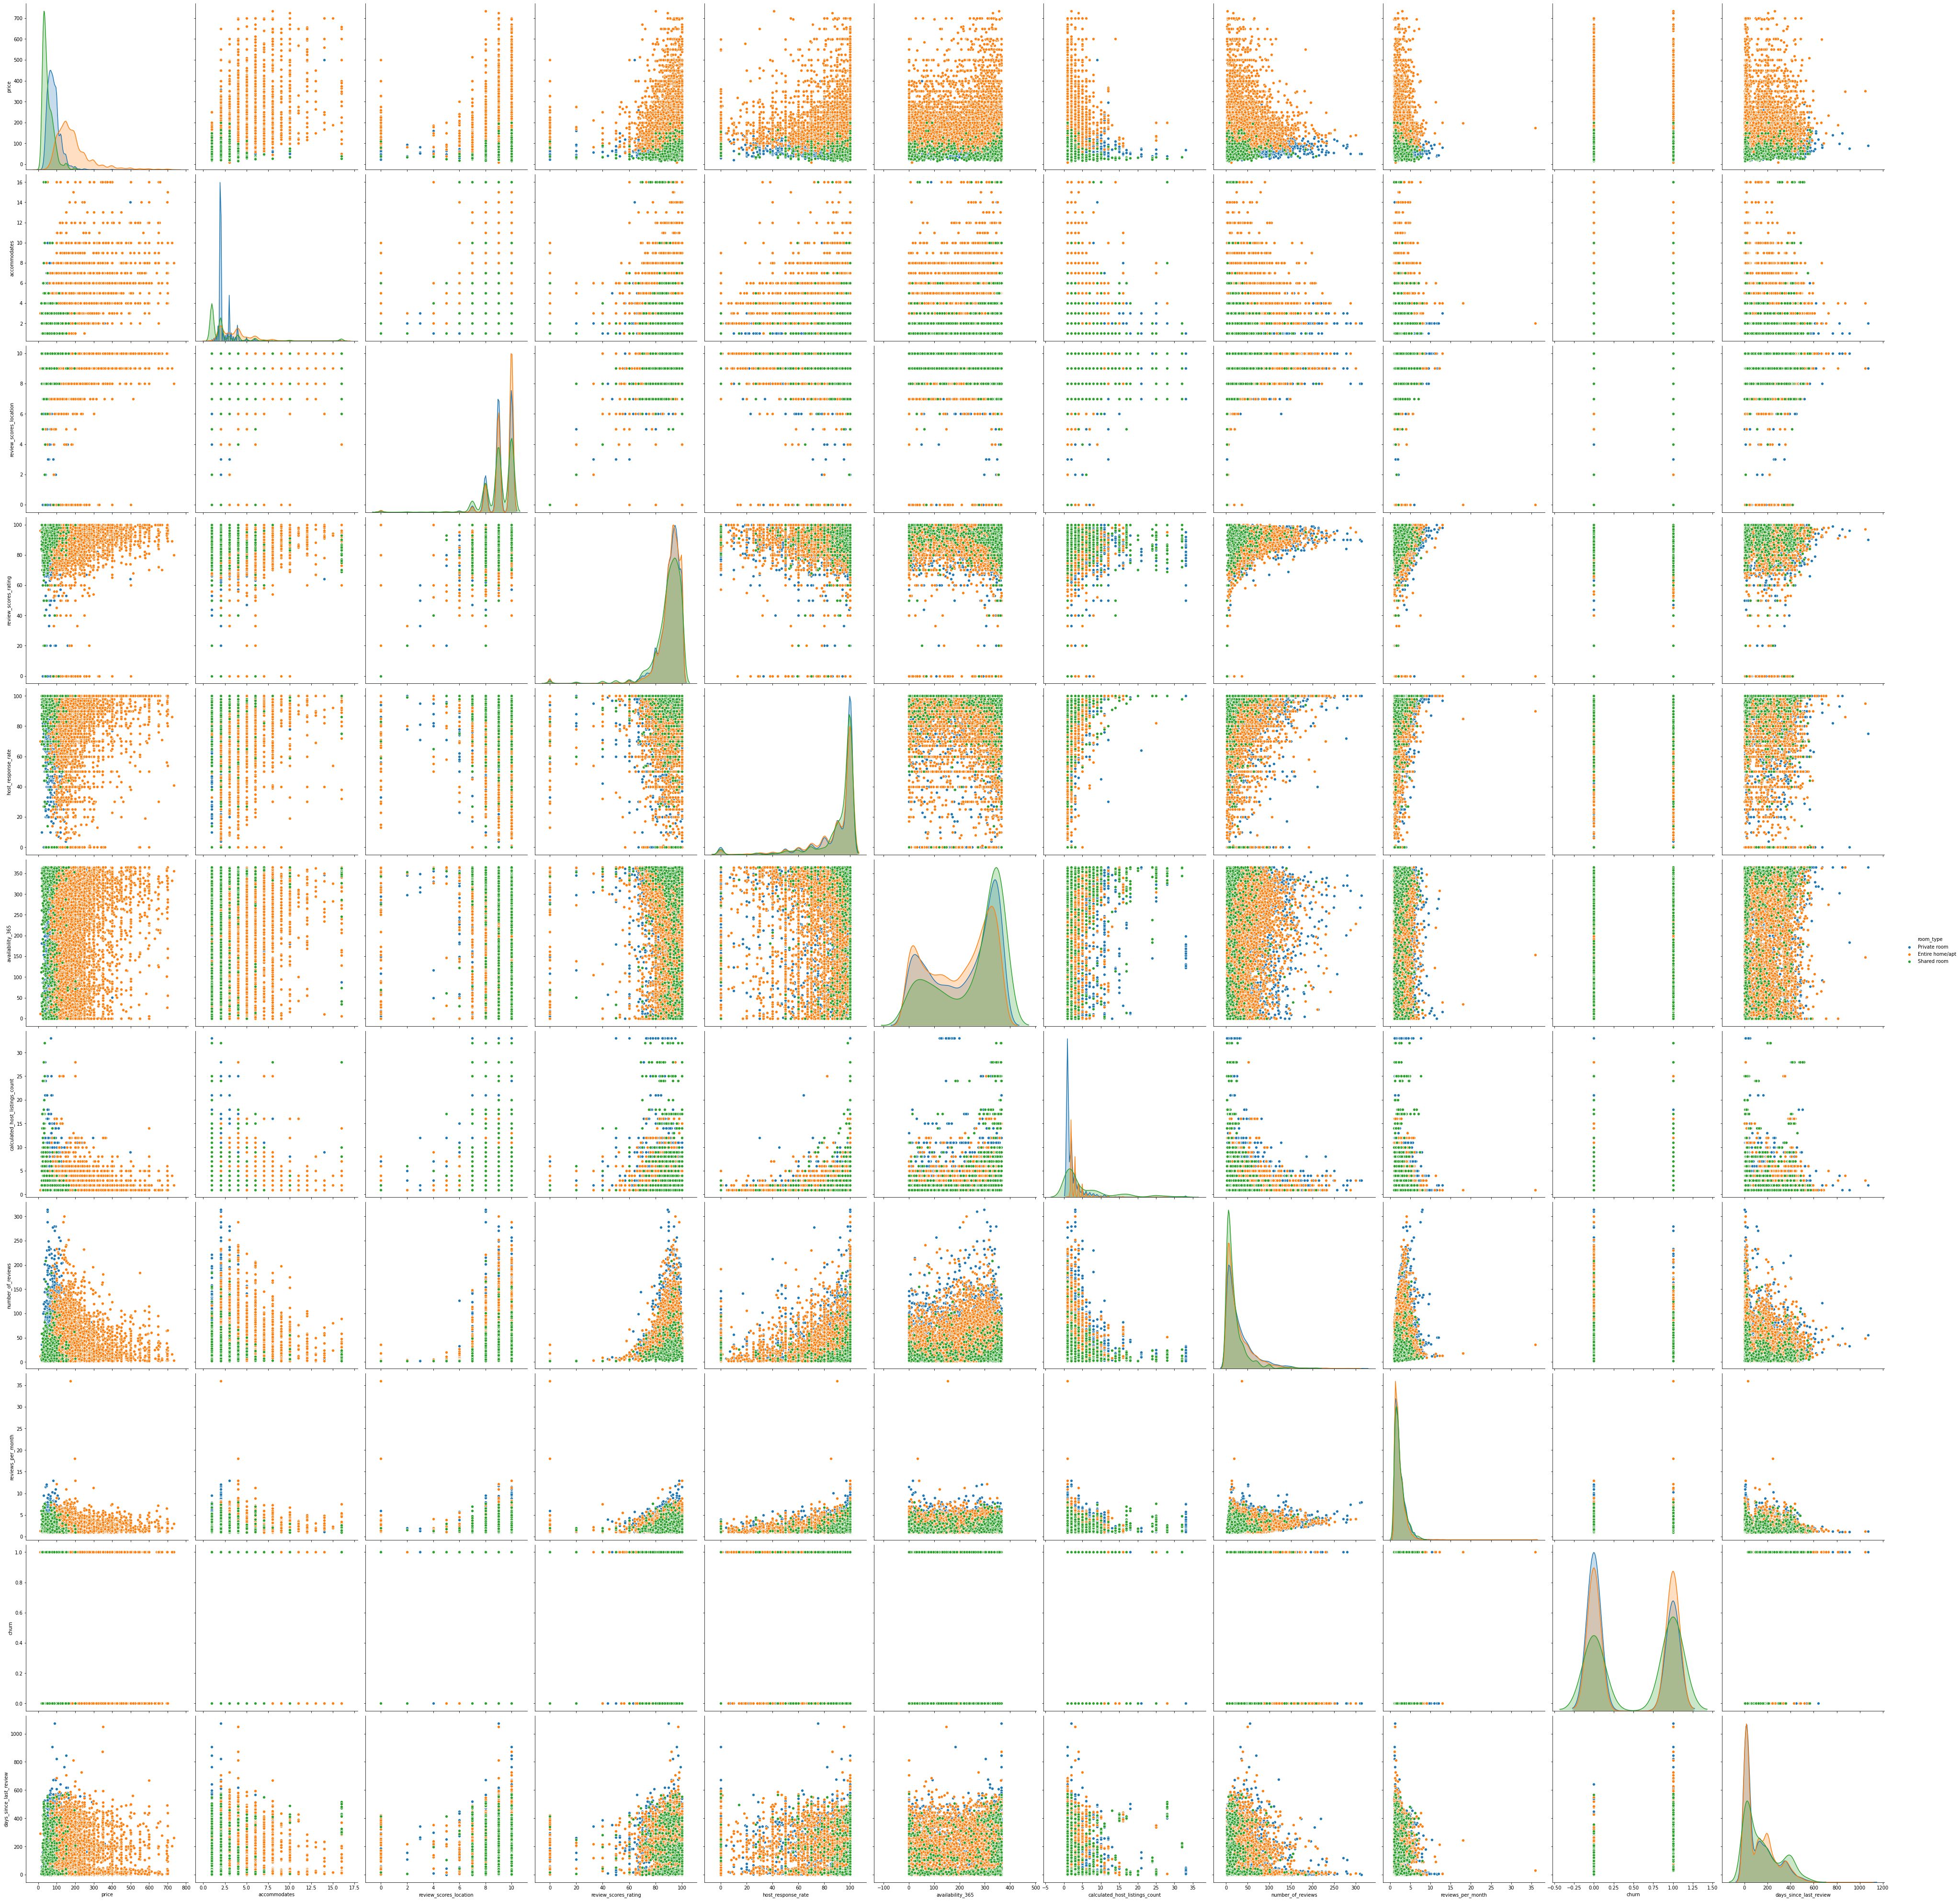

In [0]:
# may take long to compute
fig = plt.figure(figsize=(10,10))
sns.pairplot(df_sample, hue="room_type", height=5)

In [0]:
df_sample.groupby('neighbourhood').reviews_per_month.mean().sort_values()[:-30:-1]

neighbourhood
Jamaica                          2.771143
Midtown                          2.722911
Hell's Kitchen                   2.646255
Corona                           2.614667
Flushing                         2.558000
Times Square/Theatre District    2.548295
East Village                     2.492773
Mott Haven                       2.488148
Bedford-Stuyvesant               2.483807
Ditmars / Steinway               2.478356
Gowanus                          2.441795
Bushwick                         2.437002
Astoria                          2.435036
East Harlem                      2.405789
Union Square                     2.405319
East Flatbush                    2.365208
Kips Bay                         2.364806
Ridgewood                        2.352169
Nolita                           2.339801
Williamsburg                     2.332197
Chelsea                          2.320615
Hamilton Heights                 2.318769
Washington Heights               2.303174
Soho                

In [0]:
df_sample.groupby('neighbourhood').price.mean().sort_values()[:-30:-1]

neighbourhood
Tribeca                          296.089286
Soho                             262.210526
Flatiron District                232.636364
Union Square                     225.021277
West Village                     215.951220
Midtown                          209.544304
Meatpacking District             203.220000
Times Square/Theatre District    202.602273
Greenwich Village                197.130435
Battery Park City                196.896552
Chelsea                          196.640385
Nolita                           191.741722
Financial District               191.158470
Gramercy Park                    186.510204
Murray Hill                      183.650943
Hell's Kitchen                   182.109577
Midtown East                     181.972441
Kips Bay                         178.533981
Little Italy                     177.650000
East Village                     171.540832
Carroll Gardens                  167.046154
Upper West Side                  163.148387
Brooklyn Heights  

In [0]:
df_sample.groupby('churn')['price', 
                           'reviews_per_month', 
                           'number_of_reviews', 
                           'host_response_time', 
                           'host_response_rate',                     
                           'calculated_host_listings_count',
                           'days_since_last_review',
                           'review_scores_rating'].mean()

price  ...  review_scores_rating
churn             ...                      
False  135.84452  ...             92.089181
True   149.24813  ...             89.591756

[2 rows x 7 columns]

## doWhy

In [0]:
from dowhy import CausalModel

In [0]:
df_sample.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [0]:
df_why = df_sample.copy()

In [0]:
df_why['host_is_superhost'] = df_sample.host_is_superhost == 't'

In [0]:
model=CausalModel(
        data=df_why,
        treatment='host_is_superhost',
        outcome='price',
        common_causes=['room_type', 
                        'accommodates',                     
                        'review_scores_rating'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['host_is_superhost'] on outcome ['price']


In [0]:
!apt install -y graphviz
!apt install libgraphviz-dev
!pip install Pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


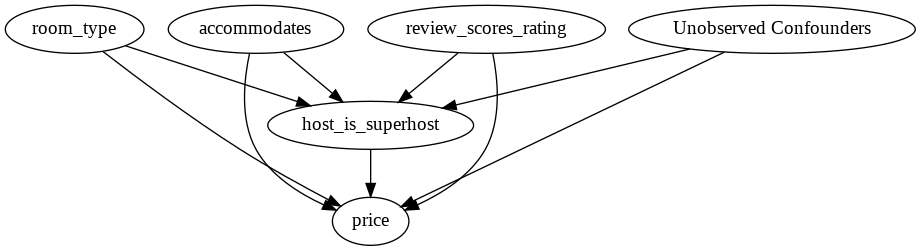

In [0]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [0]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['accommodates', 'room_type', 'review_scores_rating', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [0]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating


![](http://nickchk.com/anim/Animation%20of%20Matching.gif)

In [0]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
───────────────────(Expectation(price|accommodates,room_type,review_scores_rat
d[hostᵢₛ ₛᵤₚₑᵣₕₒₛₜ]                                                           

     
ing))
     
Estimand assumption 1, Unconfoundedness: If U→{host_is_superhost} and U→price then P(price|host_is_superhost,accommodates,room_type,review_scores_rating,U) = P(price|host_is_superhost,accommodates,room_type,review_scores_rating)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: price~host_is_superhost+accommodates+room_type+review_scores_rating
Target units: ate

## Estimate
Mean value: 0.47634347634347635



In [0]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating+w_random


Refute: Add a Random Common Cause
Estimated effect:0.47634347634347635
New effect:12.578529578529578



In [0]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Match

KeyboardInterrupt: ignored

In [0]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.9 simulated datasets of size 14285.7 each
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+review_scores_rating
INFO:dowhy.causal_

KeyboardInterrupt: ignored

## Update Model with Neighborhood Common Cause

In [0]:
model=CausalModel(
        data=df_why,
        treatment='host_is_superhost',
        outcome='price',
        common_causes=['neighbourhood', 
                        'room_type', 
                        'accommodates',                     
                        'review_scores_rating'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['host_is_superhost'] on outcome ['price']


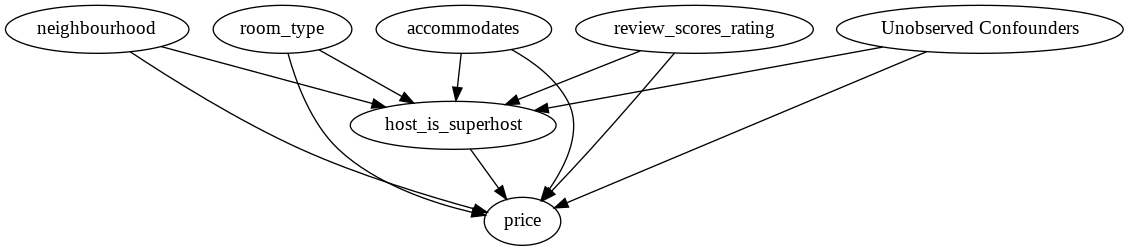

In [0]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [0]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print(f"New causal Estimate with neighbourhood is:  {estimate.value}")

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['accommodates', 'room_type', 'neighbourhood', 'review_scores_rating', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+neighbourhood+review_scores_rating


New causal Estimate with neighbourhood is:  19.825363825363826


In [0]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~host_is_superhost+accommodates+room_type+neighbourhood+review_scores_rating+w_random
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+neighbourhood+review_scores_rating


Refute: Add a Random Common Cause
Estimated effect:19.825363825363826
New effect:5.482265482265483



INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+neighbourhood+review_scores_rating
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: price~placebo+accommodates+room_type+neighbourhood+review_scores_rating


KeyboardInterrupt: ignored